In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Saving as a scenario

In [29]:
!ls ../mat/*


../mat/line_fresnelastique.npy ../mat/line_vague_dense.npy    ../mat/line_vague_solo.npy


In [51]:
%%writefile ../scenario_line_master.py
#!/usr/bin/env python
# -*- coding: utf8 -*-

import elasticite as el
import numpy as np
import os

def master(e, filename):
    if e.structure: N_lame = e.N_lame-e.struct_N
    else: N_lame = e.N_lame

    def montage(z, z_in):
        print (z_in[0, 0], z[-1, 0], z_in[0, 0], z_in[-1, 0])
        z_in[:, 0] += z[-1, 0] + 1./e.desired_fps # increment the time on the new array
        print (z.shape, z_in.shape, z_in[0, 0], z_in[-1, 0])
        return np.vstack((z, z_in))

    
    matpath = 'mat/'
    z_s = {}
    for scenario in ['line_vague_dense', 'line_vague_solo', 'line_fresnelastique']:
        z_s[scenario] = np.load(os.path.join(matpath, scenario + '.npy'))
    
    ###########################################################################
    burnout_time = 4.
    z = np.zeros((1, N_lame+1)) # zero at zero
    z = np.vstack((z, np.hstack((np.array(burnout_time), np.zeros(N_lame) ))))
    ###########################################################################
    z = montage(z, z_s['line_vague_dense'])
    ###########################################################################
    z = montage(z, z_s['line_vague_solo'])
    ###########################################################################
    z = montage(z, z_s['line_fresnelastique'])
    ###########################################################################
    z = montage(z, z_s['line_vague_dense'])
    
    ###########################################################################
    # save the file
    np.save(filename, z)

        

if __name__ == "__main__":
    import sys
    if len(sys.argv)>1: mode = sys.argv[1]
    else: mode = 'both'
        
    filename='mat/master.npy'
    
    e = el.EdgeGrid(N_lame=25, grid_type='line', mode=mode,
                 verb=True, filename=filename)

    master(e, filename)

    # running the code
    el.main(e)


Overwriting ../scenario_line_master.py


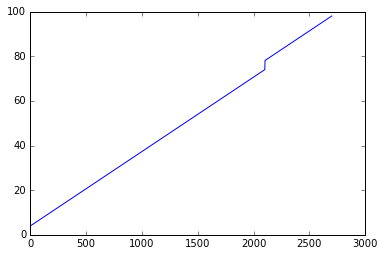

In [52]:
z = np.load('../mat/master.npy')
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(z[:, 0])

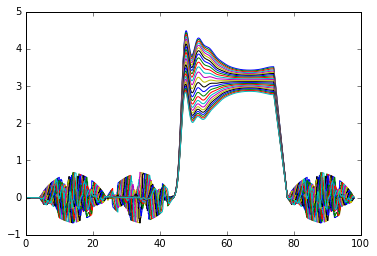

In [54]:
_ = plt.plot(z[:, 0], z[:, 1:])

## git


In [33]:
! git add 2015-11-26*
!git s

M  "2015-11-26 \303\251lasticit\303\251 - sc\303\251nario montage.ipynb"
M  "2015-11-26 \303\251lasticit\303\251 - sc\303\251nario vague.ipynb"
 M ../src/elasticite.py
?? ../mat/line_fresnelastique.npy
?? ../mat/master.npy
?? ../scenario_line_master.py
?? ../scenario_master.py


In [34]:
!git commit -am' scenario master '

[master 1f9351c]  scenario master
 3 files changed, 12324 insertions(+), 7463 deletions(-)
 rewrite "posts/2015-11-26 \303\251lasticit\303\251 - sc\303\251nario vague.ipynb" (71%)


In [ ]:
! git push
